<a href="https://colab.research.google.com/github/PGPradhan/Sales-Forecasting/blob/og-sales-forecasting/notebook_sales_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Product Sales Forecasting using Quantitative Methods

In a personal endevaour to learn about time series analysis and forecasting, I decided to reserach and explore various quantitative forecasting methods. This notebook documents the methods that can be applied to forecast product sales, along with a detailed explaination of the different metrics used to evaluate the forecasts.

<b>Goal:</b> The goal of this project was to apply various quantitative methods, (i.e. Times Series Models and Causal Models) to forecast the sales of the products available in the dataset obtained from Kaggle.

<b> Models covered in the notebook include: </b> <br>
1. Seasonal Naive Model
2. Holt-Winters Model (Triple Exponential Smoothing)
3. ARIMA and Seasonal ARIMA Models
4. Linear Regression Model

### Import the required libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

### Load Dataset

The dataset contanins historical sales records of 10 stores and 50 products, from the year 2013 through 2017.

In [2]:
df = pd.read_csv('/content/train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


### Missing Values Imputation
There are no missing values in the dataset.

In [3]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

### Data Preprocessing
For the purpose of this project, we will only look at the sales of 'item' - 1 from 'store' - 1. The dataset is split into train and test sets, where the train set contains sales record from January 2013 to September 2017 and the test set (validation set) contains sales records of the last three month of 2017.

Some new features have been created from the date field, for the purpose of exploratory data analysis and causal modelling.

In [4]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 1]

df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)

# Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2017-09-30'].reset_index(drop=False)
test_df = temp_df.loc['2017-10-01':].reset_index(drop=False)

train_df.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [5]:
test_df.head()

,date,store,item,sales,year,month,day,weekday
0,2017-10-01,1,1,21,2017,10,1,6
1,2017-10-02,1,1,12,2017,10,2,7
2,2017-10-03,1,1,18,2017,10,3,1
3,2017-10-04,1,1,15,2017,10,4,2
4,2017-10-05,1,1,20,2017,10,5,3


### Data Exploration
The plots below try to capture the trend and distribution of sales through weeks, months and years.

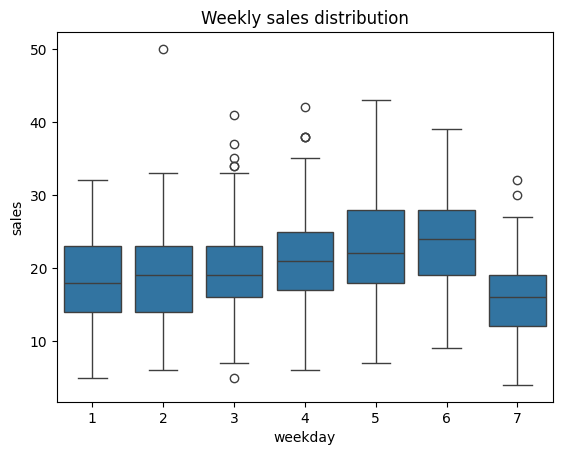

In [6]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

<b>Inference:</b>  The average number of sales increases over the week, is maximum on Saturday (6), and takes a sharp fall on Sunday (7)

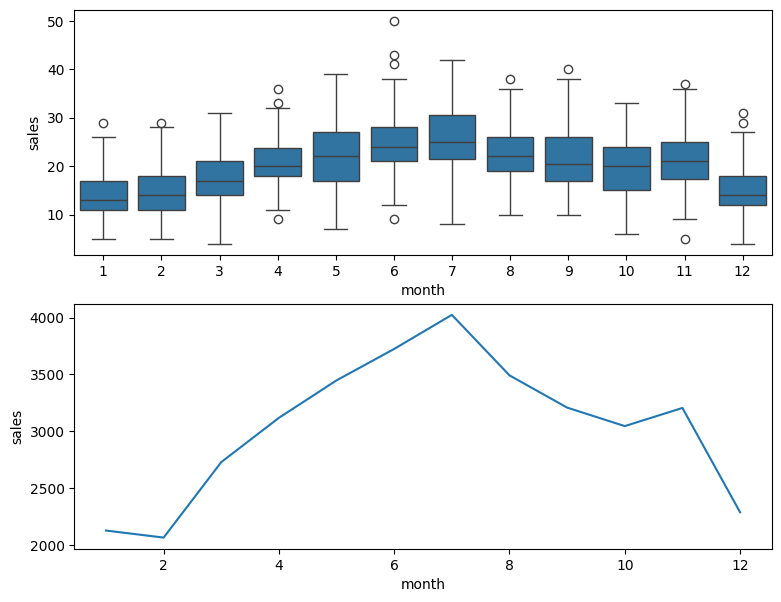

In [7]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

<b>Inference:</b>  The number of sales gradually ascends in the first half of the year starting February (2), peaks in July (7), and then gradually descends, before slightly increasing in November (11) and then dropping again in December (12).

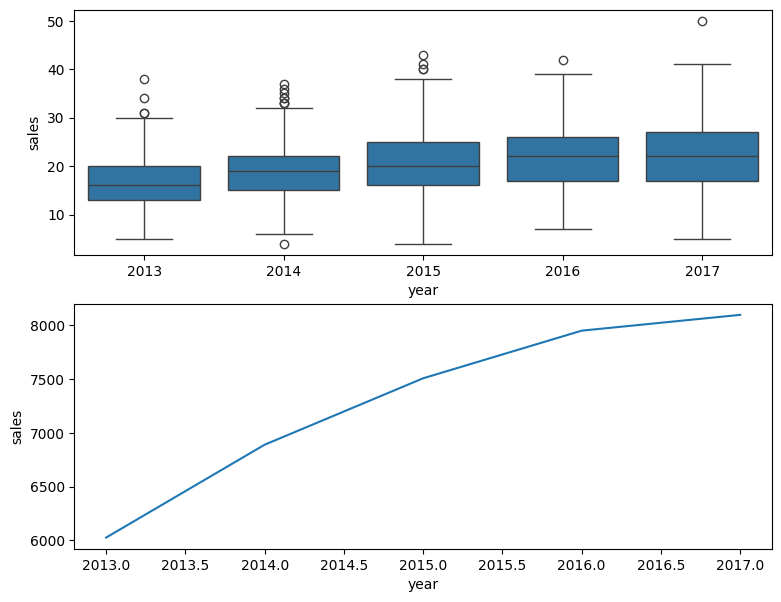

In [8]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

<b>Inference:</b>  From the number of sales vs. year plot, we can infer an increasing trend over the years. The aggregate number of sales has increased from approximately 6000 in 2013 to slightly over 8000 in 2017, i.e. a <b>33.3% increase in the number of sales</b> approximately. A clear trend is captured by the lineplot above.

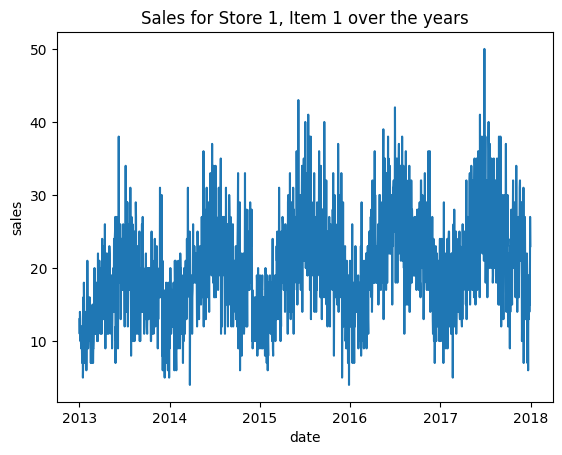

In [9]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

<b>Inference:</b> There is a seasonal pattern in the number of sales of 'item' - 1 at 'store' - 1. As also infered in the plot for sales vs. month above, we can see an increase in the sales in the first half of the year, peaking in July, and then a gradual decrease till December. This pattern is repeated each year, 2013 onwards.

### Quantitative Methods to Forecast Product Sales

It can be fairly concluded from the data exploratory plots above that there is seasonality present in the product sales data, along with a greneral increase in the number of sales over the years. Therefore, in order to forecast the number of sales for the last three months of 2017, we will keep in mind the linear trend and seasonality present in the product sales. <br>
There are multiple ways to approach the forecasting problem, we can either build traditional time series models, or use causal models, such as linear regression. We will look at both these methods and try to evaluate our forecasts using the validation set.

### 1. Baseline Model: Seasonal Naive

Before we get to the more advanced time-series forecasting methods, let's take a look at a basic method - Seasonal Naive. It can serve as a quick calculation to get a baseline until something better can come along. Or, perhaps there is very little variance in the data, then this method can be good enough.

<b> What is Seasonal Naive? </b>

It is a naive method that takes the seasonal patterns into account by looking at what happened same time last year. For example, if we want to predict the sales during December 2017, the seasonal naive method will assume the same number of sales for December 2017 as was in December 2016. Fortunately, we have at least one-year of sales data, this method might make no sense otherwise. <br>

In the code below, one year is subtracted from the dates in the test data, and one day is added to the resulting difference, after which they are looked up in the training data to return the sales from those respective dates. So keeping the seasonality in mind, we now have our naive forecasts based on the number of sales from a year ago.

In [10]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]')
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['sales']

# make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

,date,store,item,year,month,day,weekday,seasonal_naive_sales
0,2017-10-01,1,1,2017,10,1,6,25
1,2017-10-02,1,1,2017,10,2,7,26
2,2017-10-03,1,1,2017,10,3,1,20
3,2017-10-04,1,1,2017,10,4,2,28
4,2017-10-05,1,1,2017,10,5,3,17


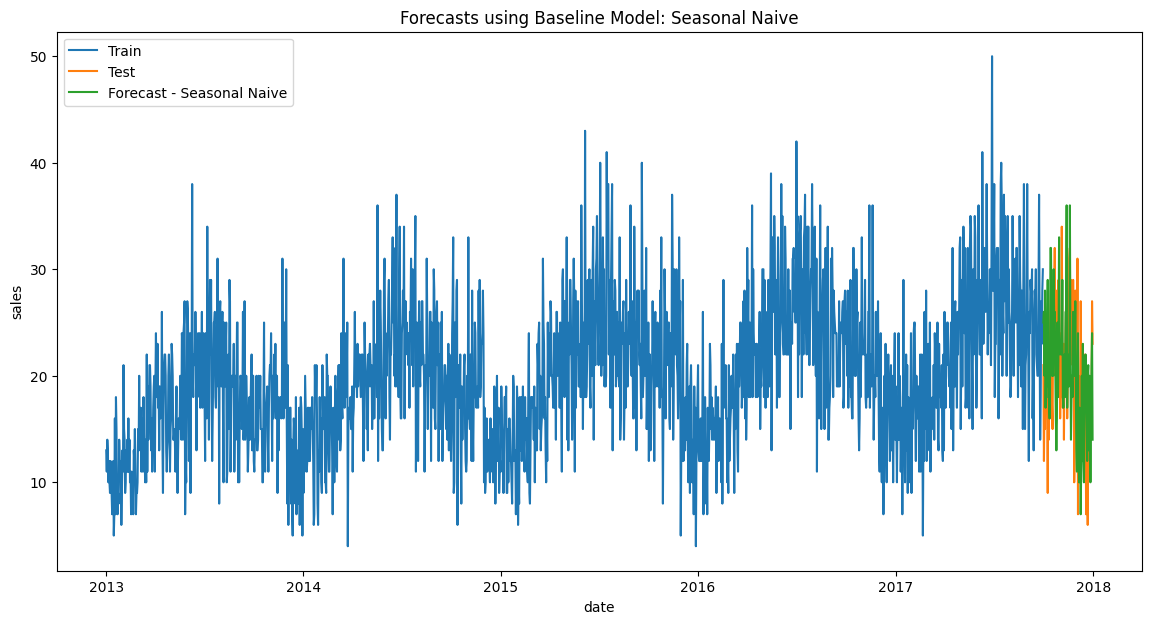

In [11]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

<b> Inference: </b> To the naked eye, the forecasts seem alright the decreasing trend is clearly captured by our naive method. However, we will formally quantify the performance using forecast accuracy metrics.

<b> Evaluating the Forecasts </b>

There are number of widely accepted forecasting metrics, and the most common metric is <b>forecast error</b>. The error can simply be calculated by finding the diffrence between the actual sales value and the forecasted sales value. For example, if 10 items are sold on a day, and you predicted 14 items to be sold, you have an error of -4.

In order to evaluate the overall forecast, we will look at metrics like <b>mean absolute error</b> (MAE), <b>root mean squared error</b> (RMSE) and a percentage error metric - <b>mean absolute percentage error</b> (MAPE).

+ <b>MAE:</b> It is the absolute value of the error, summed for each observed day, and divided by the total number of observed days.

+ <b>RMSE:</b> It is similar to MAE, however rather than the absolute value, the error is squared before it is summed, and then the square root is taken to normalize the units. Because we take the square of the error, we wind up punishing large forecasting errors more than small ones.

The above two metrics are scale-dependent meaning that we cannot use them to compare forecasts on different scales. MAPE on the other hand is a scale-independent metric.

+ <b>MAPE:</b> It can be used for meaningful comparisions, it is calculated by dividing the sum of absolute errors by sum of actual sales to get a percentage indicator that is scaled to the actual sales.

Let's apply the above metrics to our forecasts and see how they compare.

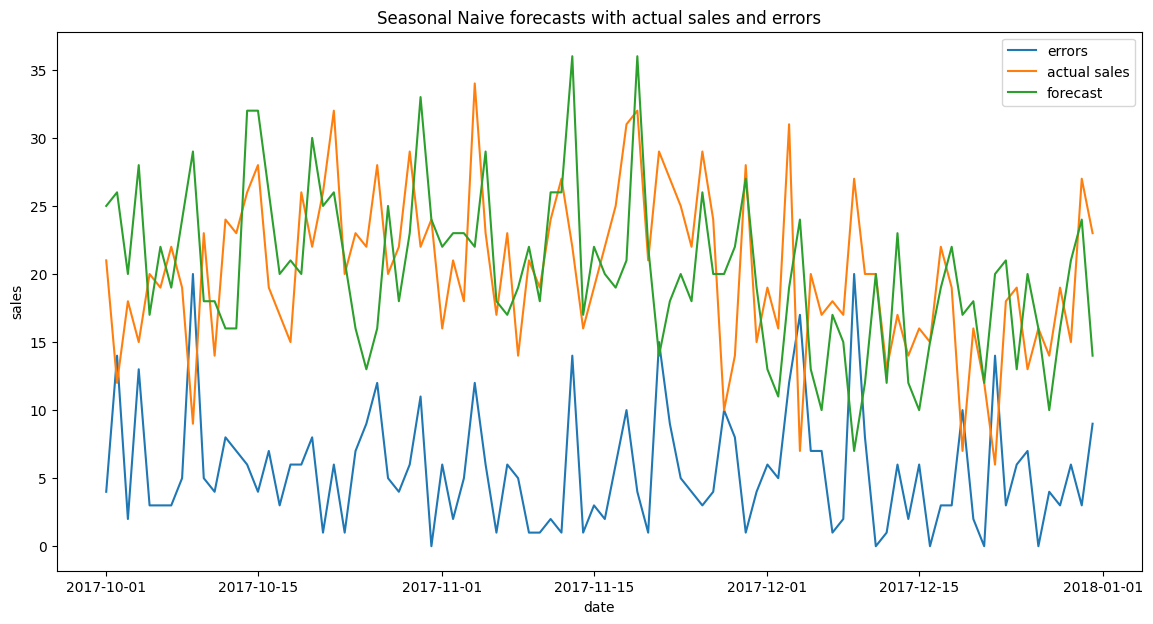

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1861,1857,4,5.630435,7.130766,27.834498


In [12]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae),
                                           RMSE=('errors', rmse),
                                           MAPE=('errors', mape))


plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

The overall error is not as bad, and we were able to achieve a <b>MAPE of 27.8%</b>. We will use this as a <b>benchmark</b> to judge the forecast performance of the other models. Let's move on to a more advanced model that uses Exponential Smoothing, but before that let's take a look at the time series decomposition plot for our training data.

### Time Series Decomposition Plot

A time series decomposition plot allows us to observe the seasonality, trend, and error/remainder terms
of a time series. These three components are a crucial part of the Exponential Smoothing models. Therfore, the decomposition plot helps in deciding the type of Exponential Smoothing Model to use for our forecasts.

In [13]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-01,1,1,13.0,2013,1,1,1
2013-01-02,1,1,11.0,2013,1,2,2
2013-01-03,1,1,14.0,2013,1,3,3
2013-01-04,1,1,13.0,2013,1,4,4
2013-01-05,1,1,10.0,2013,1,5,5


<Figure size 640x480 with 0 Axes>

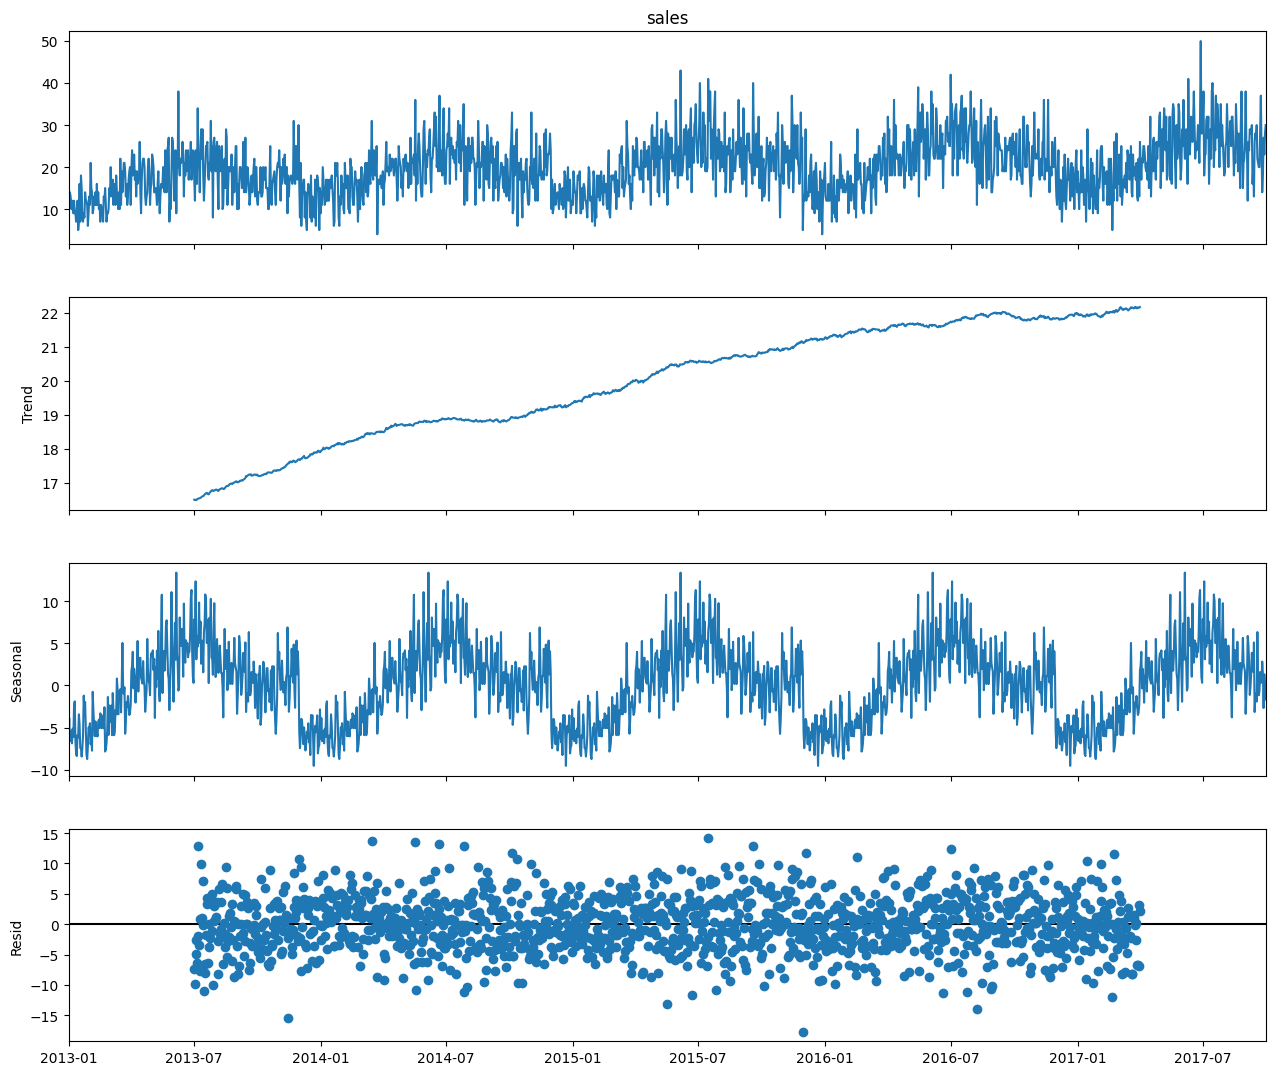

In [15]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive', period=365)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)


### Determine Error, Trend and Seasonality

An ETS model has three main components: error, trend, and seasonality. Each can be applied either additively, multiplicatively, or not at all. We will use the above Times Series Decomposition Plot to determine the additive or multiplicative property of the thre components.

1. Trend - If the trend plot is linear then we apply it additively (A). If the trend line grows or shrinks exponentially, we apply it multiplicatively (M). If there is no clear trend, no trend component is included (N).

2. Seasonal - If the peaks and valleys for seasonality are constant over time, we apply it additively (A). If the size of the seasonal fluctuations tends to increase or decrease with the level of time series, we apply it multiplicatively (M). If there is no seasonality, it is not applied (N).

3. Error - If the error plot has constant variance over time (peaks and valleys are about the same size), we apply it additively (A). If the error plot is fluctuating between large and small errors over time, we apply it multiplicatively (M).

<b> For our sales data, we see a linear trend plot and a constant seasonality over time, so we will apply trend and seasonality additively. The error component also has constant variance, so we will apply it additively too. </b>

<b> We will use a Exponential Smoothing, a commonly-used local statistical algorithm for time-series forecasting. The Exponential Smoothing method can be defined in terms of an ETS framework, in which the components are calculated using a smoothing technique. </b>

### What is Exponential Smoothing?

This is a very popular scheme to produce a smoothed Time Series. Whereas in Single Moving Averages the past observations are weighted equally, <b>Exponential Smoothing assigns exponentially decreasing weights as the observation get older</b>. In other words, recent observations are given relatively more weight in forecasting than the older observations. <br>
In the case of moving averages, the weights assigned to the observations are the same and are equal to 1/N. In exponential smoothing, however, there are one or more smoothing parameters to be determined (or estimated) and these choices determine the weights assigned to the observations. <br>


There are 3 kinds of smoothing techniques Single, Double and Triple Exponential Smoothing.
1. <b>Single Exponential Smoothing</b> is used when the time series does not have a trend line and a seasonality component.
2. <b>Double Exponential Smoothing</b> is used to include forecasting data with a trend, smoothing calculation includes one for the level, and one for the trend.
3. <b>Triple Exponential smoothing</b> is used when data has trend and seasonality. We include a third equation to take care of seasonality (sometimes called periodicity). The resulting set of equations is called the "Holt-Winters" (HW) method after the names of the inventors.

Since out data has both trend and seasonality components, we will apply Triple Exponential Smoothing.

### 2. Holt Winter's Triple Exponential Smoothing Model
Use this link to get a better understanding of the math behind Triple Exponential Smoothing: https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


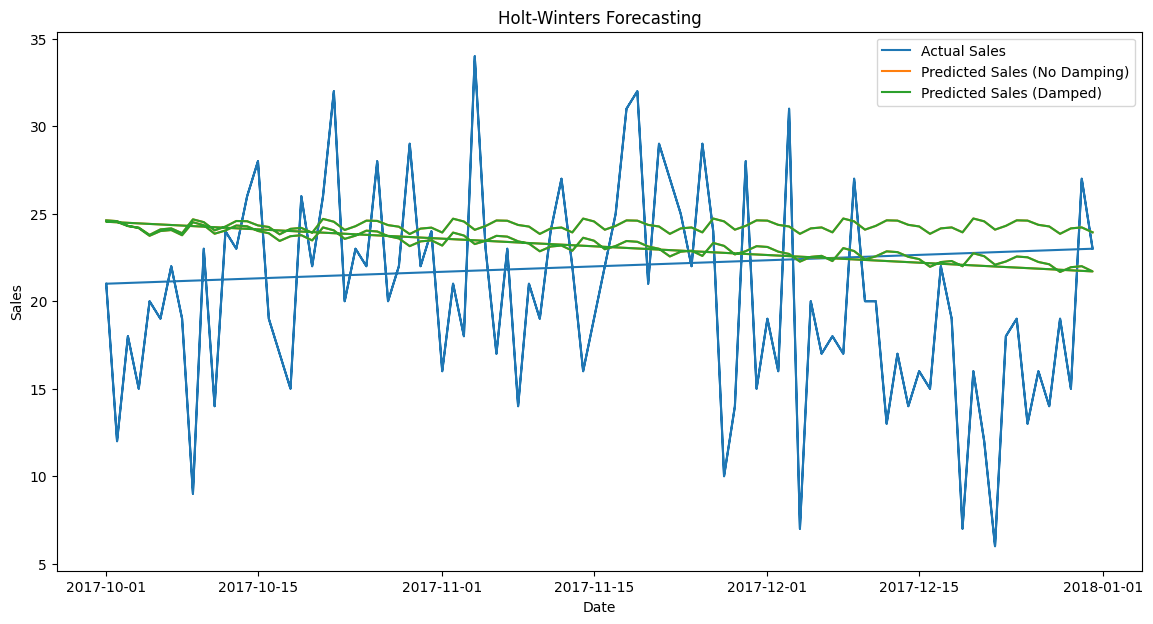

                         model       date  sales  pred_sales     errors
0    Holt-Winters (No Damping) 2017-10-01     21   24.621840  -3.621840
1    Holt-Winters (No Damping) 2017-10-02     12   24.577059 -12.577059
2    Holt-Winters (No Damping) 2017-10-03     18   24.309157  -6.309157
3    Holt-Winters (No Damping) 2017-10-04     15   24.178123  -9.178123
4    Holt-Winters (No Damping) 2017-10-05     20   23.739227  -3.739227
..                         ...        ...    ...         ...        ...
179      Holt-Winters (Damped) 2017-12-27     14   24.272897 -10.272897
180      Holt-Winters (Damped) 2017-12-28     19   23.852761  -4.852761
181      Holt-Winters (Damped) 2017-12-29     15   24.162491  -9.162491
182      Holt-Winters (Damped) 2017-12-30     27   24.217196   2.782804
183      Holt-Winters (Damped) 2017-12-31     23   23.937386  -0.937386

[184 rows x 5 columns]


In [17]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df and test_df are your training and test DataFrames
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, use_boxcox=False)
hw_fit_1 = hw_model_1.fit(remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True, use_boxcox=False)
hw_fit_2 = hw_model_2.fit(remove_bias=False)
pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()

# Merge predictions and actual sales into one DataFrame
errors_df_hw1 = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw1 = errors_df_hw1[['date', 'sales', 'pred_sales']]
errors_df_hw1['errors'] = errors_df_hw1['sales'] - errors_df_hw1['pred_sales']
errors_df_hw1.insert(0, 'model', 'Holt-Winters (No Damping)')

errors_df_hw2 = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hw2 = errors_df_hw2[['date', 'sales', 'pred_sales']]
errors_df_hw2['errors'] = errors_df_hw2['sales'] - errors_df_hw2['pred_sales']
errors_df_hw2.insert(0, 'model', 'Holt-Winters (Damped)')

# Evaluate the predictions
result_df_hw = pd.concat([errors_df_hw1, errors_df_hw2])
result_df_hw.reset_index(drop=True, inplace=True)

# Plot the forecasts
plt.figure(figsize=(14, 7))
plt.plot(result_df_hw['date'], result_df_hw['sales'], label='Actual Sales')
plt.plot(result_df_hw['date'], result_df_hw['pred_sales'], label='Predicted Sales (No Damping)')
plt.plot(result_df_hw['date'], result_df_hw['pred_sales'], label='Predicted Sales (Damped)')
plt.legend()
plt.title('Holt-Winters Forecasting')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Display the evaluation results
print(result_df_hw)


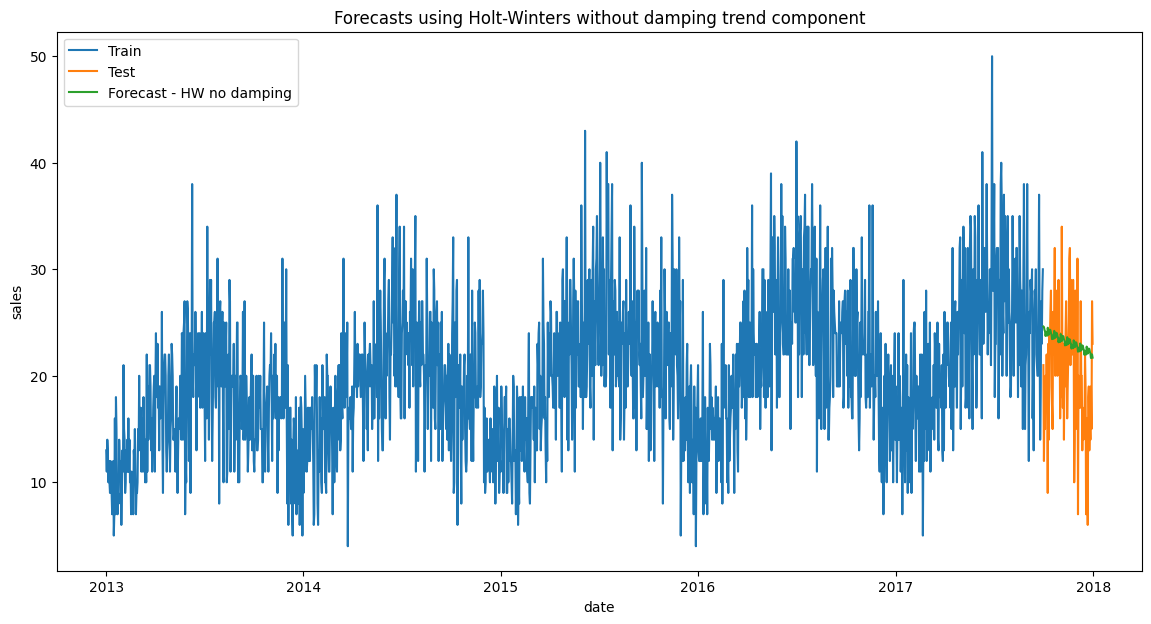

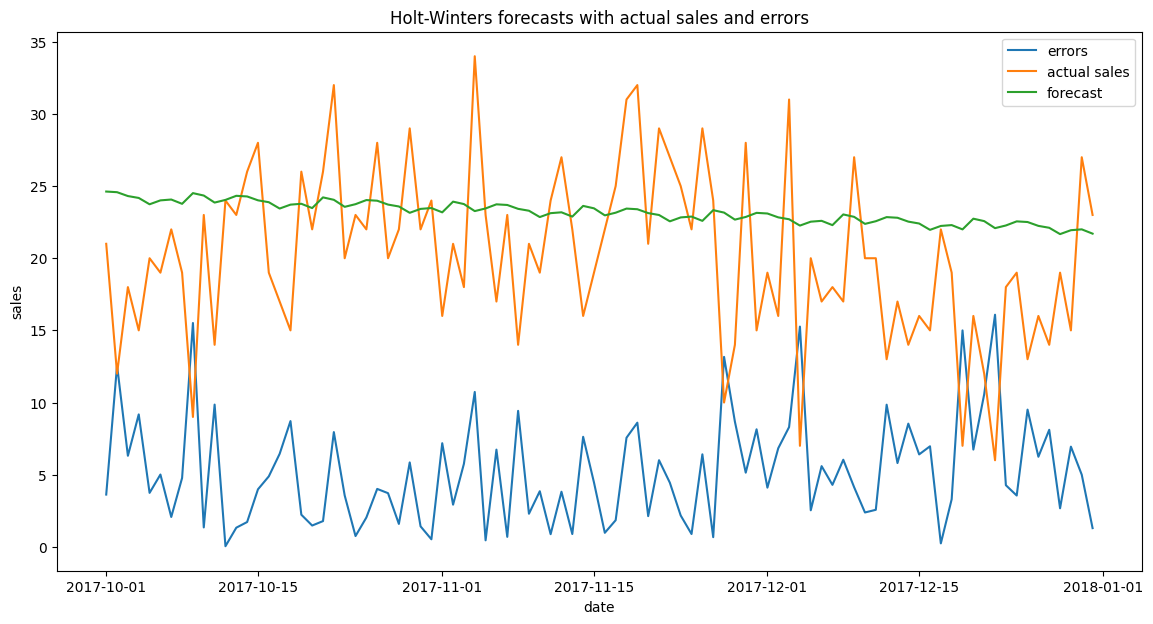

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters,1861,2132.536302,-271.536302,5.235092,6.430953,25.880088


In [18]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'sales', 'pred_sales']]
errors_df_hw['errors'] = errors_df_hw.sales - errors_df_hw.pred_sales
errors_df_hw.insert(0, 'model', 'Holt-Winters')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='Forecast - HW no damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters without damping trend component')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['sales'], label='actual sales')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters forecasts with actual sales and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_hw

<b> Inference: </b> The decreasing trend is clearly captured by the Holt-Winters method, and the <b>MAPE 22.8%</b> is better in comparision to our baseline model. Let's try Holt-Winters method with a damped parameter, and see if we can improve the results

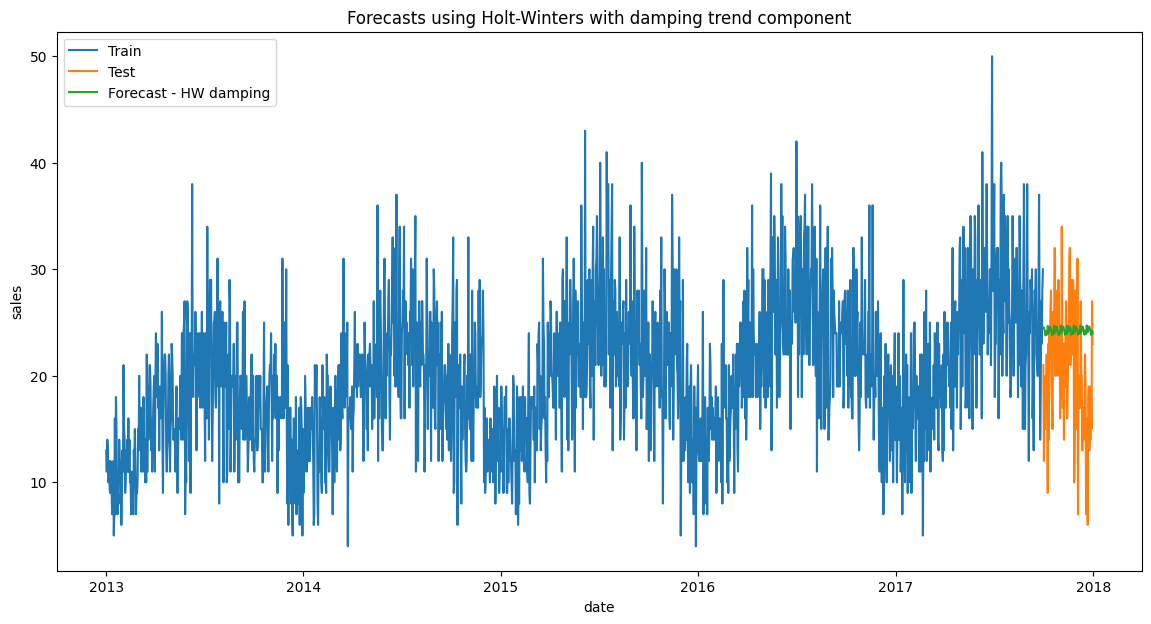

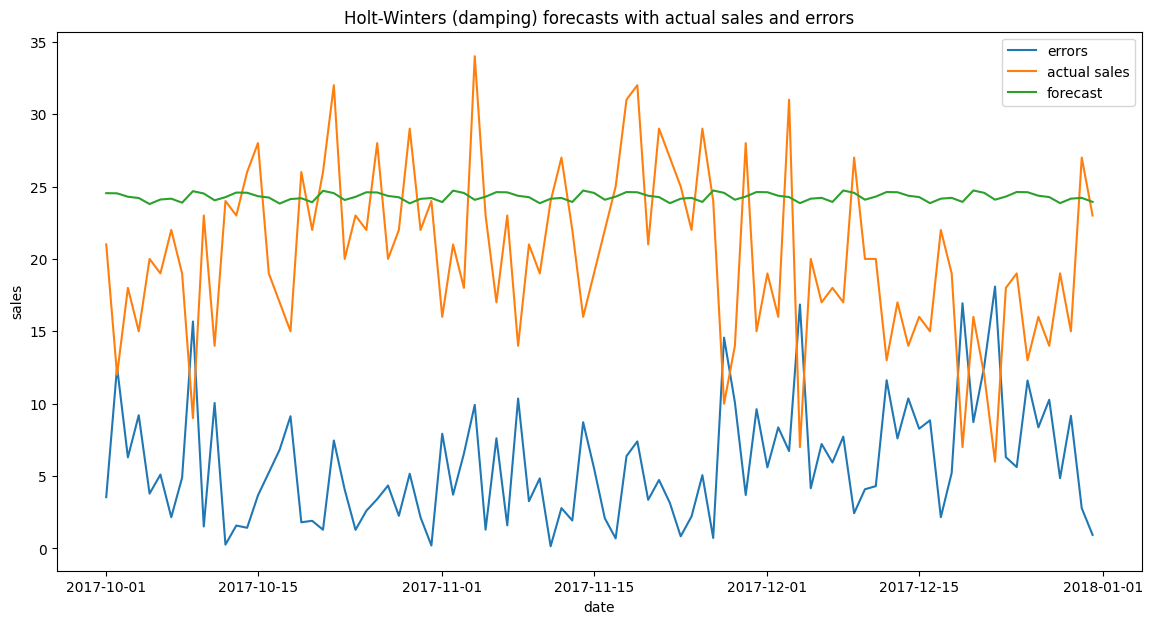

,total_sales,total_pred_sales,holt_winters_overall_error,MAE,RMSE,MAPE
model,,,,,,
Holt-Winters-Damped,1861,2234.806611,-373.806611,5.820579,7.102234,28.774489


In [19]:
# Merge predictions and actual sales into one df
errors_df_hwd = pd.merge(test_df, pred_fit_2, left_on='date', right_on='index')
errors_df_hwd = errors_df_hwd[['date', 'sales','pred_sales']]
errors_df_hwd['errors'] = errors_df_hwd.sales - errors_df_hwd.pred_sales
errors_df_hwd.insert(0, 'model', 'Holt-Winters-Damped')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='Forecast - HW damping')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Holt-Winters with damping trend component')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(errors_df_hwd['date'], np.abs(errors_df_hwd['errors']), label='errors')
plt.plot(errors_df_hwd['date'], errors_df_hwd['sales'], label='actual sales')
plt.plot(errors_df_hwd['date'], errors_df_hwd['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Holt-Winters (damping) forecasts with actual sales and errors')
plt.show()

result_df_hwd = errors_df_hwd.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          holt_winters_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_hwd

<b> Inference: </b> To the naked eye, the forecasts seem alright, however the <b>MAPE 29.7%</b> is worse than our baseline model.

Let's look at another popular time-series method: Autoregressive Integrated Moving Average (ARIMA) Model.

### 3. Autoregressive Integrated Moving Average - ARIMA Model

#### Step 1: Check stationarity

Before going any further into our analysis, our series has to be made stationary.

Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation, etc.). If the mean of a time-series increases over time, then it’s not stationary.

The mean across many time periods is only informative if the expected value is the same across those time periods. If these population parameters can vary, what are we really estimating by taking an average across time?

Stationarity requires that the statistical properties must be the same across time, making the sample average a reasonable way to estimate them.

<b> Methods to Check Stationarity </b>

1. <b>Plotting rolling statistics:</b> Plotting rolling means and variances is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not to be stationary.



2. <b>Augmented Dickey-Fuller Test:</b> This test is used to assess whether or not a time-series is stationary. It gives a result called a “test-statistic”, based on which you can say, with different levels (or percentage) of confidence, if the time-series is stationary or not. The <b>test statistic</b> is expected to be negative; therefore, it has to be more <b>negative(less)</b> than the <b>critical value</b> for the <b>hypothesis to be rejected</b> and conclude that <b>series is stationary</b>.



3. <b> ACF and PACF plots: </b> An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself. A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags.
Ideally, we want no correlation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

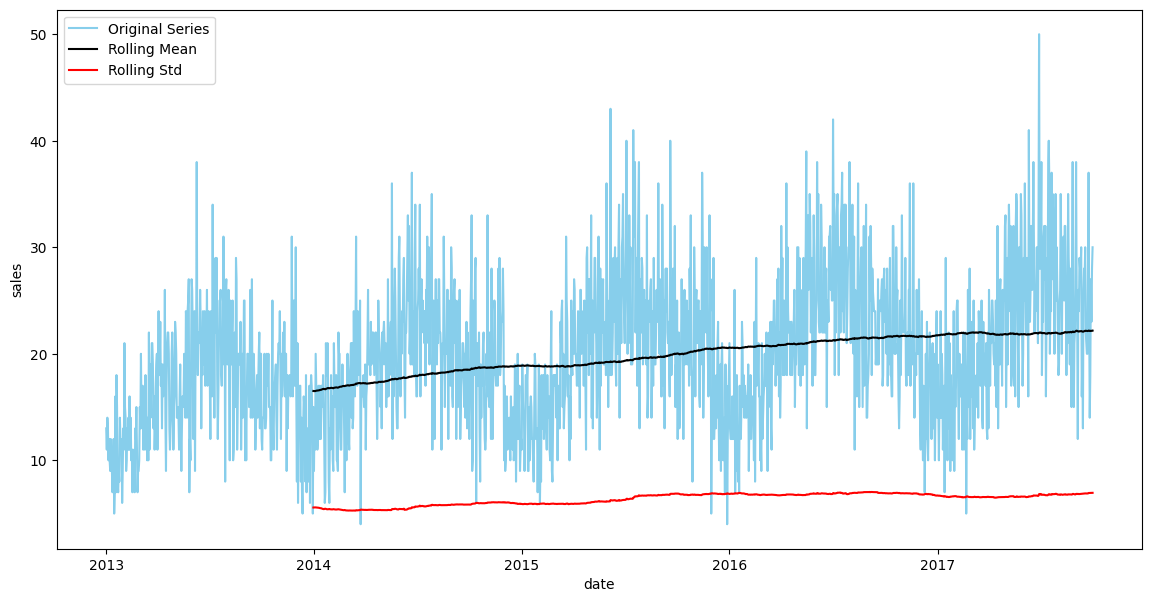

Test statistic = -2.937
P-value = 0.041
Critical values :
	1%: -3.434179908502461 - The data is not stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


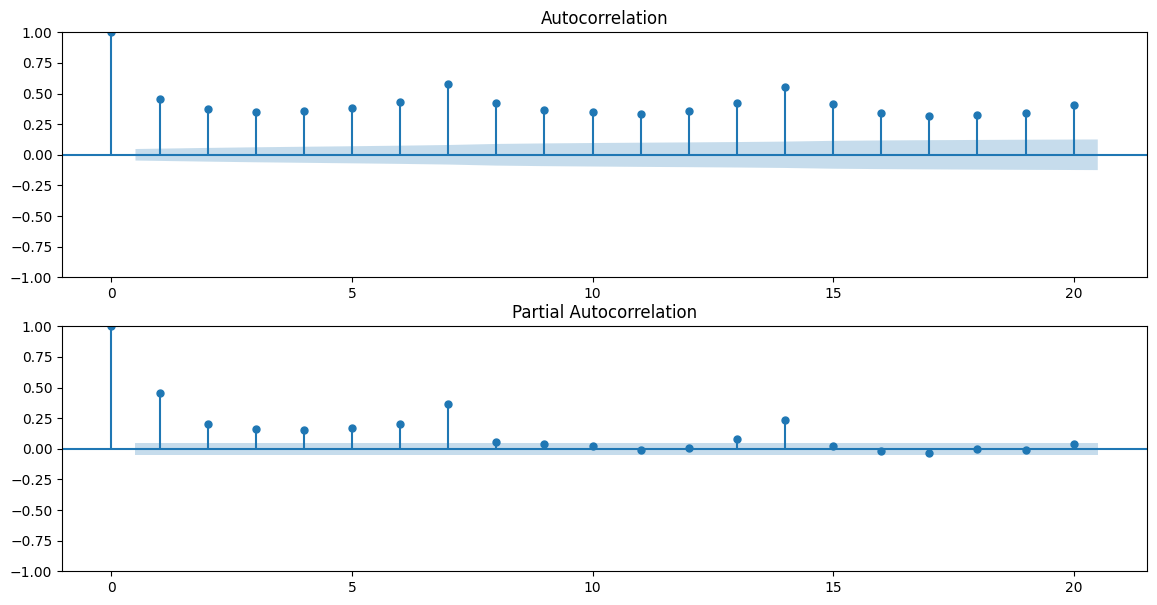

In [20]:
arima_df = train_df[['date', 'sales']].set_index('date')
arima_test_df = test_df[['date', 'sales']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('sales')
    plt.show()

    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")

    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))

    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)

test_stationarity(arima_df.sales)

Looking at the results from our test, we can conclude that the series is not stationary. Therefore, in order to make the series stationary we apply <b> Differencing </b>

#### Step 2: Differencing

<b>Differencing:</b> Seasonal or cyclical patterns can be removed by substracting periodical values. If the data is 12-month seasonal, substracting the series with a 12-lag difference series will give a “flatter” series. Since we have aggregated the data to each day-level, we will shift by 1.

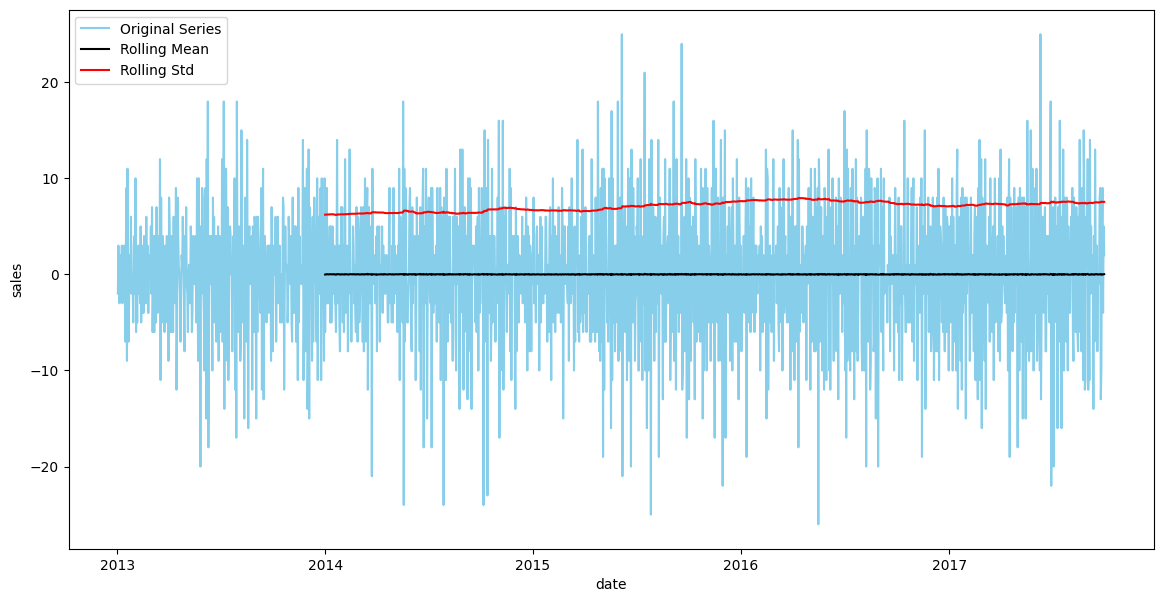

Test statistic = -12.326
P-value = 0.000
Critical values :
	1%: -3.434179908502461 - The data is  stationary with 99% confidence
	5%: -2.863231689892687 - The data is  stationary with 95% confidence
	10%: -2.567670609760268 - The data is  stationary with 90% confidence


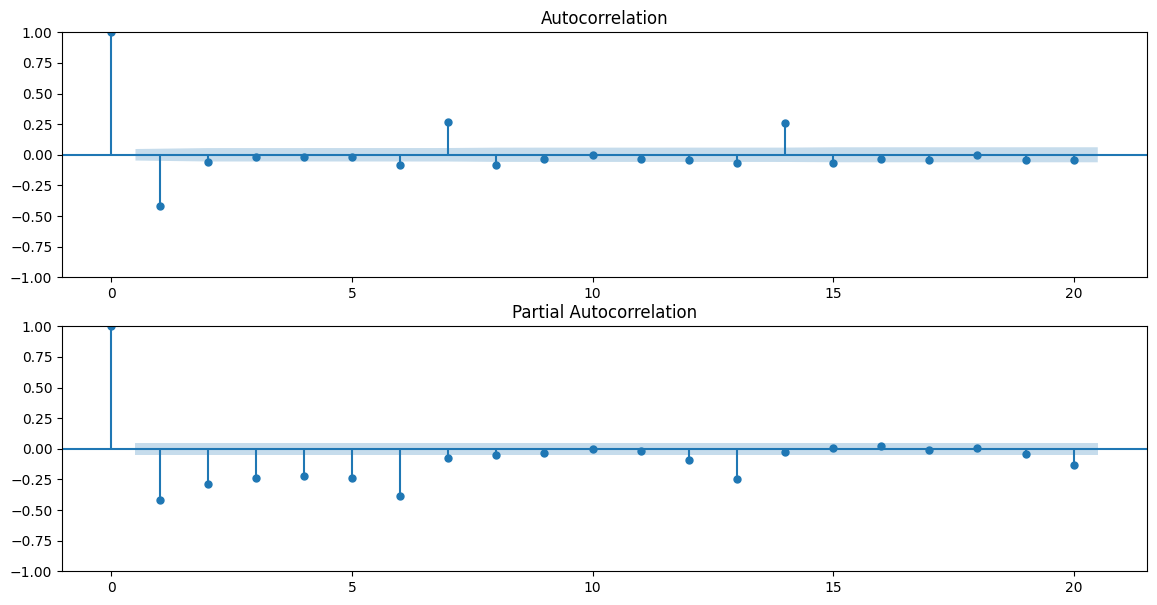

In [21]:
first_difference = arima_df.sales - arima_df.sales.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.sales)

After applying Differencing to the series, we can see from the above results that the series is now stationary, i.e. mean and variance are constant over time, and from ADF we can verify that the test-statistic is lesser than the critical value, hence we can reject the null hypothesis and conclude that the series is staionary.

#### Step 3: Model Building
#### Interpreting the AR(p), I(d), MA(q) values:

1. <b>Determining I(d):</b>

    Taking the first order difference makes the time series stationary. Therefore, <b>I(d) = 1.</b>
    

2. <b>Determining AR(p):</b> If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1.

    From the PACF plot we can clearly observe that within 6 lags the AR is significant. Therefore, we can use <b>AR(p) = 6</b>,  (6 lines are crossed the blue lines so 6past days are required to predict).


3. <b>Determining MA(q):</b> If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1.

    From tha ACF plot we see a negative spike at lag 1, therfore we can use <b> MA(q) = 1</b>

In [32]:
from statsmodels.tsa.arima.model import ARIMA

arima_model61 = ARIMA(arima_df.sales, order=(6, 1, 1)).fit()
print(arima_model61.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                 1734
Model:                 ARIMA(6, 1, 1)   Log Likelihood               -5306.648
Date:                Mon, 18 Mar 2024   AIC                          10629.296
Time:                        04:10:27   BIC                          10672.957
Sample:                    01-01-2013   HQIC                         10645.443
                         - 09-30-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6039      0.051    -11.899      0.000      -0.703      -0.504
ar.L2         -0.6032      0.040    -15.019      0.000      -0.682      -0.524
ar.L3         -0.5652      0.037    -15.248      0.0

### Plotting the residuals using ACF and PACF

Plotting the residuals shows that recurring correlation exists in both ACF and PACF. So we need to deal with seasonality. When the plots of ACF and PACF are similar or any sesaonality is present between them then, we need to apply the Seasonal ARIMA (SARIMA) model.

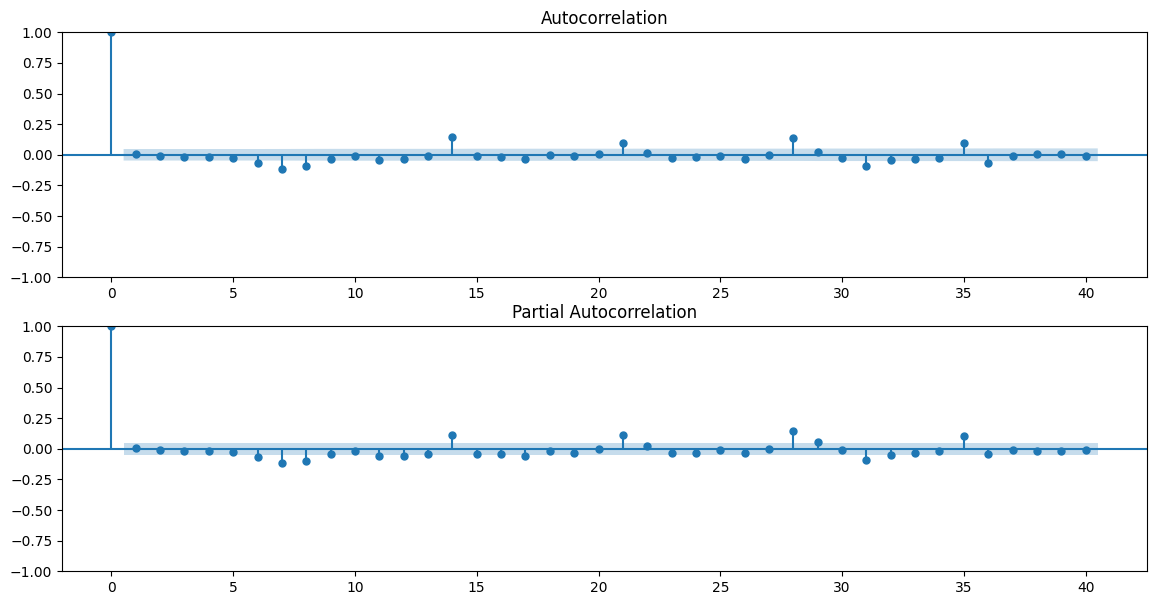

In [33]:
residuals = arima_model61.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


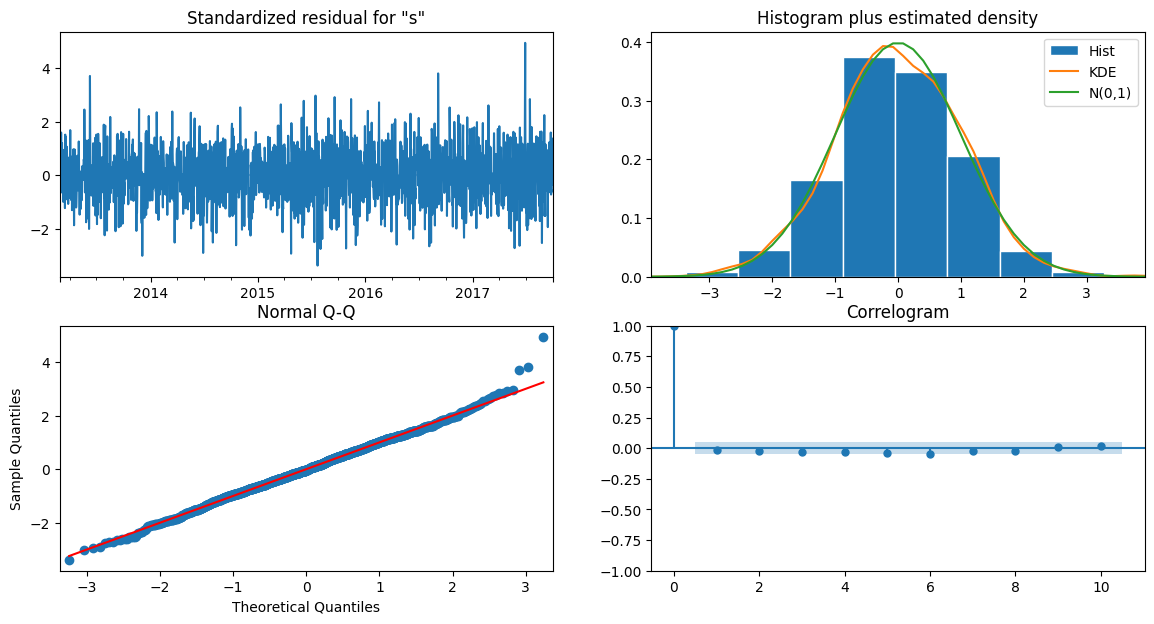

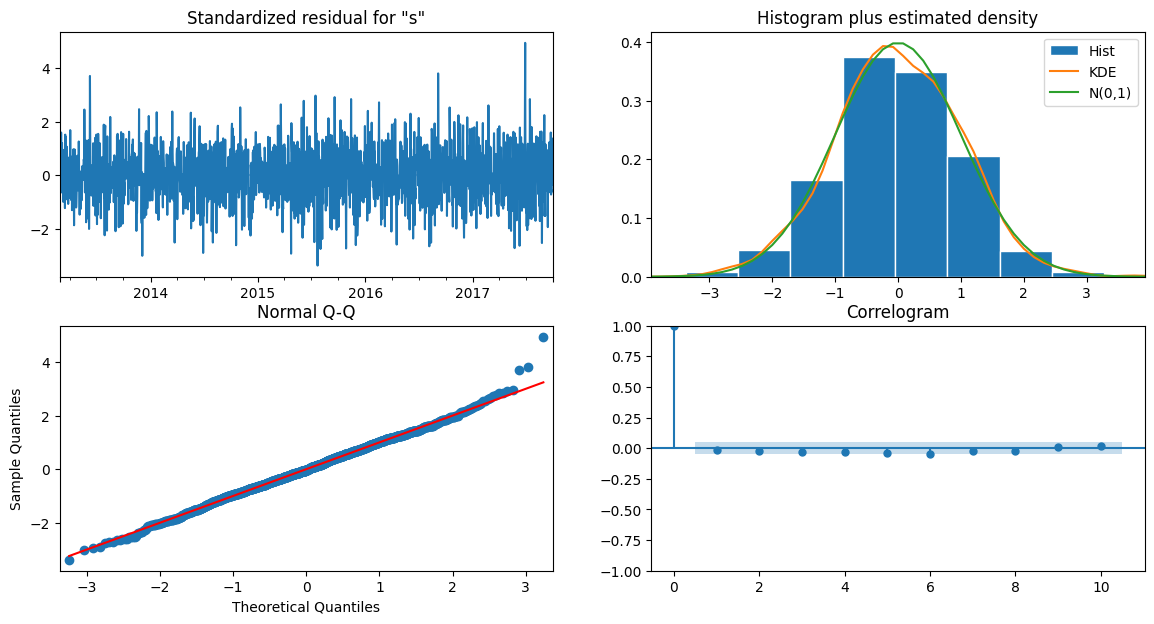

In [34]:
# fit the model
sarima_model = SARIMAX(arima_df.sales, order=(6, 1, 0), seasonal_order=(6, 1, 0, 7),
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
arima_test_df['pred_sales'] = sarima_fit.predict(start=arima_test_df.index[0],
                                                 end=arima_test_df.index[-1], dynamic= True)
plot = sarima_fit.plot_diagnostics(figsize=(14,7))
plot

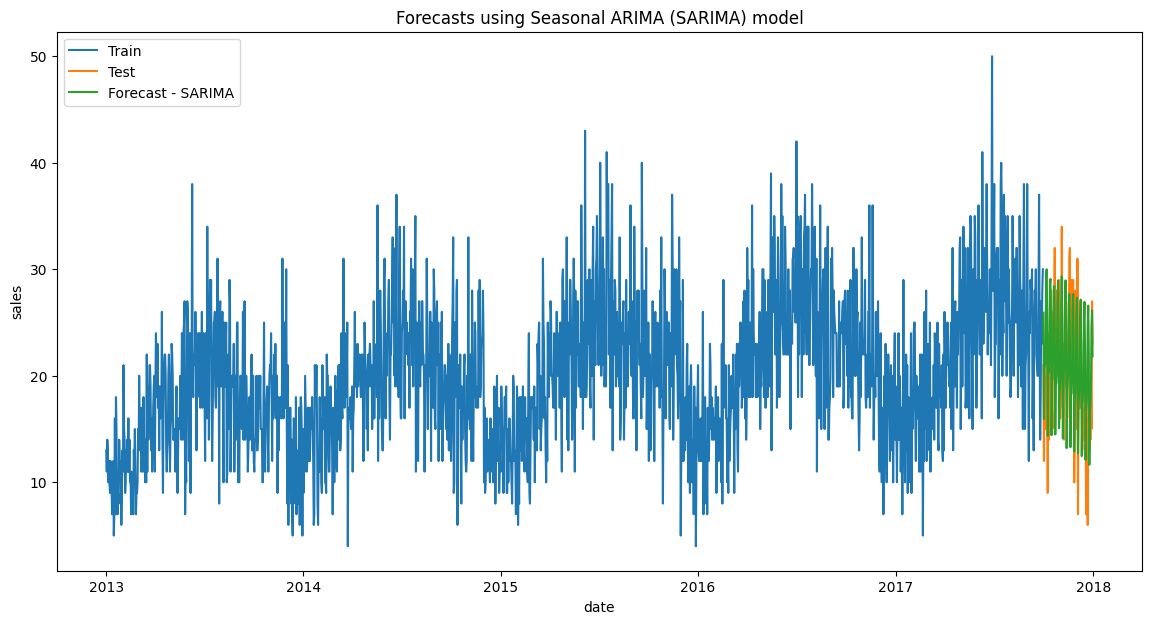

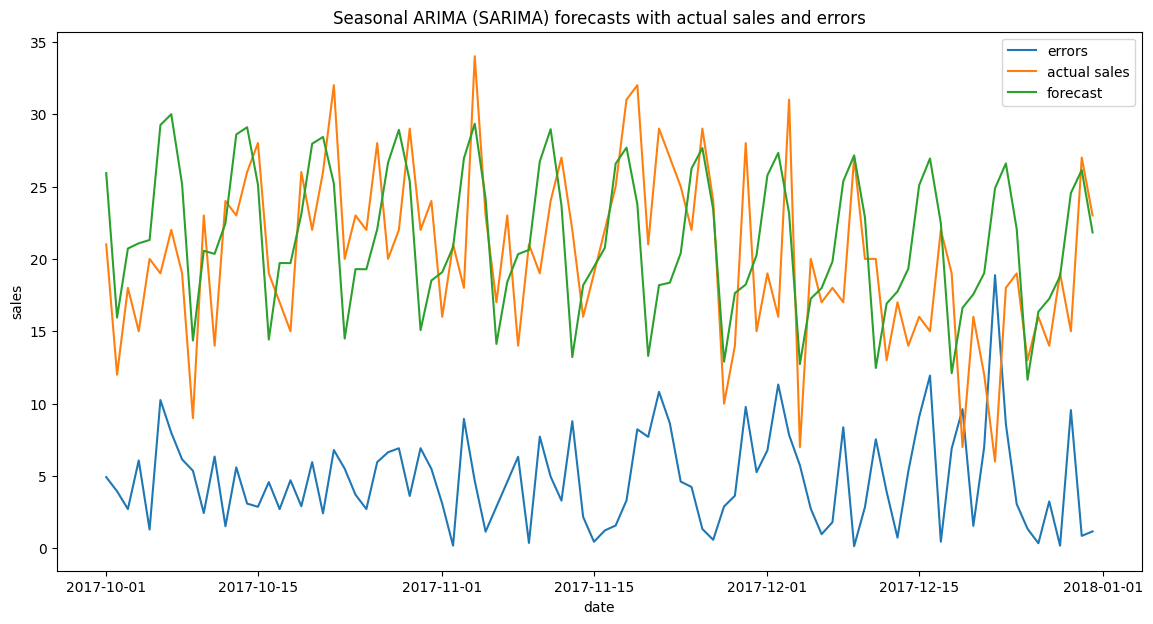

,total_sales,total_pred_sales,SARIMA_overall_error,MAE,RMSE,MAPE
model,,,,,,
SARIMA,1861,1973.197447,-112.197447,4.799933,5.839147,23.728846


In [36]:
# Replace existing 'model' column with 'SARIMA'
arima_test_df['model'] = 'SARIMA'

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='Test')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='Forecast - SARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Seasonal ARIMA (SARIMA) model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.index, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.index, arima_test_df['sales'], label='actual sales')
plt.plot(arima_test_df.index, arima_test_df['pred_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal ARIMA (SARIMA) forecasts with actual sales and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          SARIMA_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_sarima


<b>Inference: </b> The SARIMA model with <b>MAPE of 23.7%</b> performed better than our baseline model, but couldn't better the Holt-Winter's Triple Exponential Smoothing method.

Let's look at a Causal method:  Regression, in order to forecast our sales data

### 4. Supervised Machine Learning: Linear Regression

Let's apply Linear Regression to our time series data in order to forecasts sales.

In [37]:
reg_df = df
reg_df

,date,store,item,sales,year,month,day,weekday,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_max,rolling_min
0,2013-01-01,1,1,13,2013,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11,2013,1,2,2,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14,2013,1,3,3,11.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13,2013,1,4,4,14.0,11.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10,2013,1,5,5,13.0,14.0,11.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,27,2,16.0,13.0,19.0,18.0,6.0,12.0,16.0,14.000000,19.0,6.0
1822,2017-12-28,1,1,19,2017,12,28,3,14.0,16.0,13.0,19.0,18.0,6.0,12.0,15.000000,19.0,6.0
1823,2017-12-29,1,1,15,2017,12,29,4,19.0,14.0,16.0,13.0,19.0,18.0,6.0,16.285714,19.0,13.0
1824,2017-12-30,1,1,27,2017,12,30,5,15.0,19.0,14.0,16.0,13.0,19.0,18.0,17.571429,27.0,13.0


#### Step 1: Feature Engineering

In [38]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)

# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2017-09-30']
reg_test_df = reg_df.loc['2017-10-01':]

#### Step 2: Feature Selection and Model Building

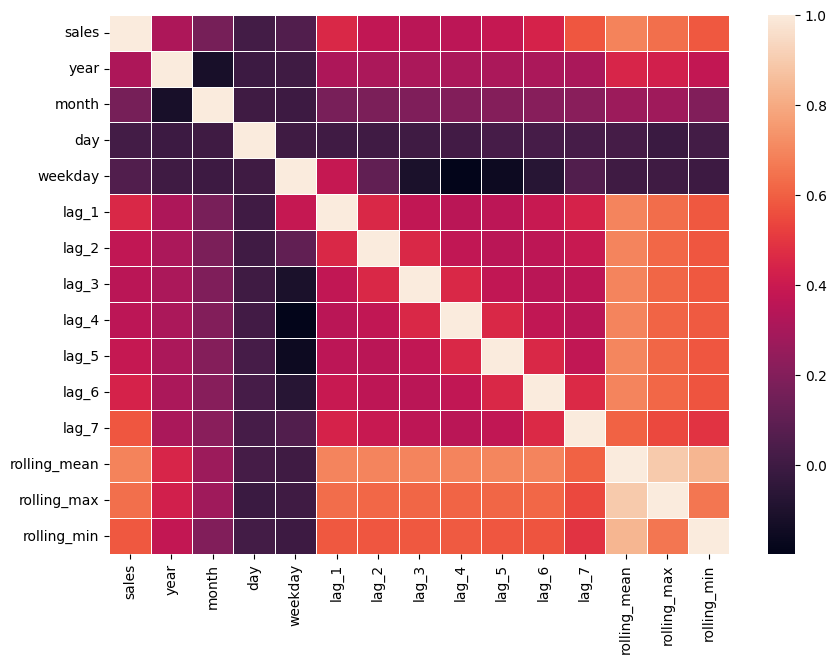

In [39]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [40]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature        Score
11  rolling_mean  1577.946956
12   rolling_max  1170.464035
13   rolling_min   888.451268
10         lag_7   860.565955
4          lag_1   449.743115


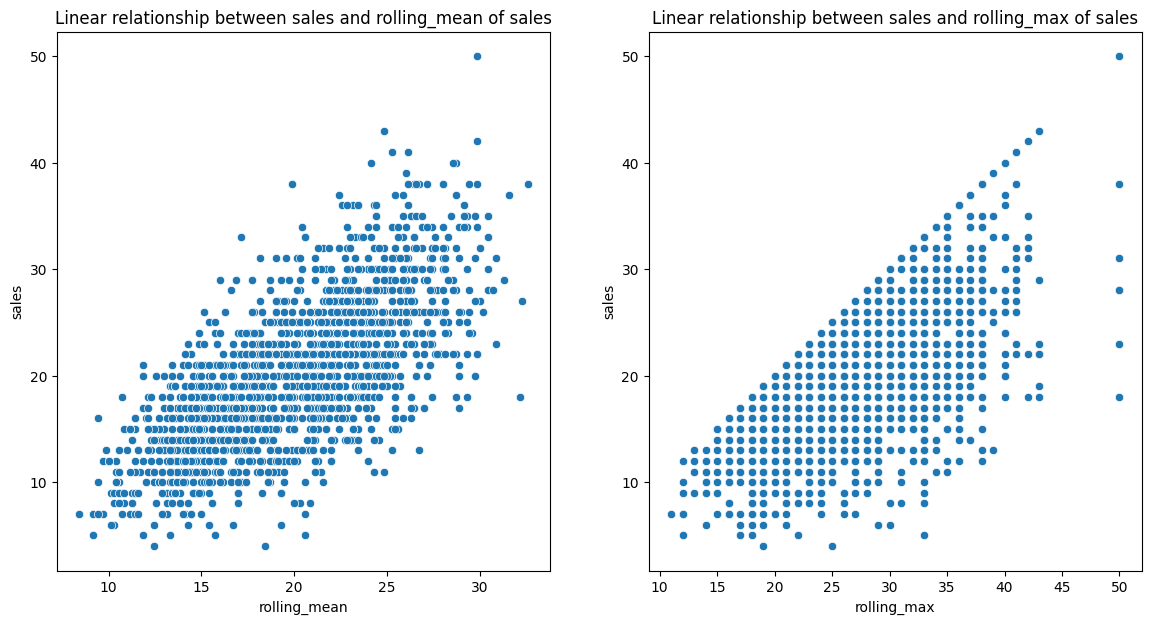

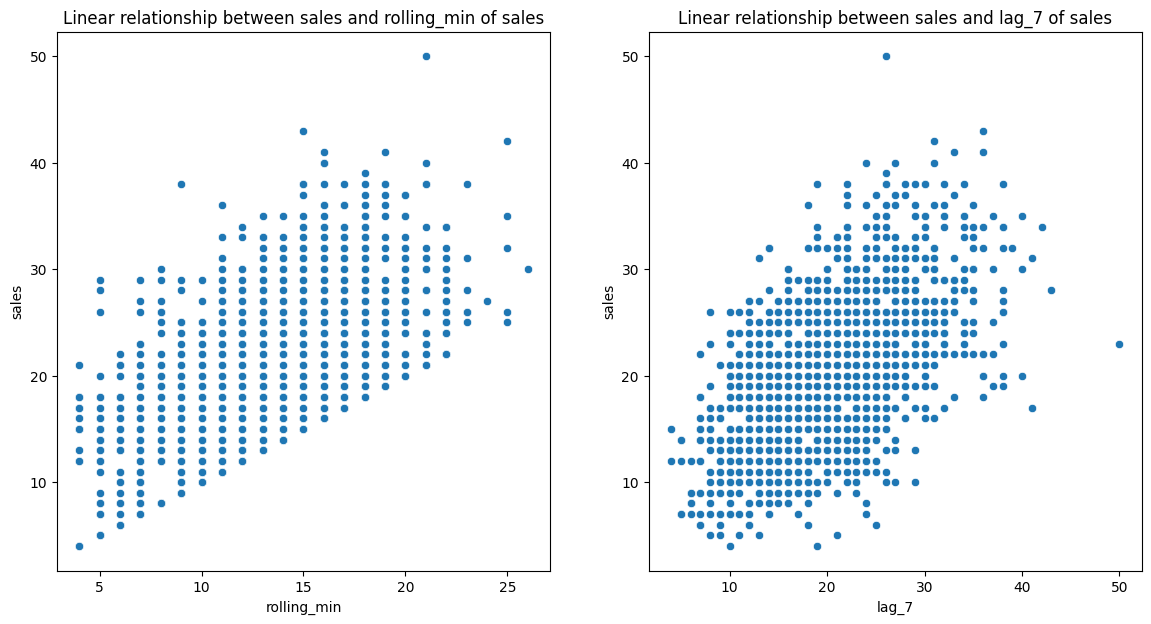

In [42]:
import seaborn as sn

# Checking for a linear relationship of the top features with sales (target variable)
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(x=reg_train_df.rolling_mean, y=reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(x=reg_train_df.rolling_max, y=reg_train_df.sales, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(x=reg_train_df.rolling_min, y=reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(x=reg_train_df.lag_7, y=reg_train_df.sales, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')


In [43]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

#### Step 3: Model Evaluation and Predictions

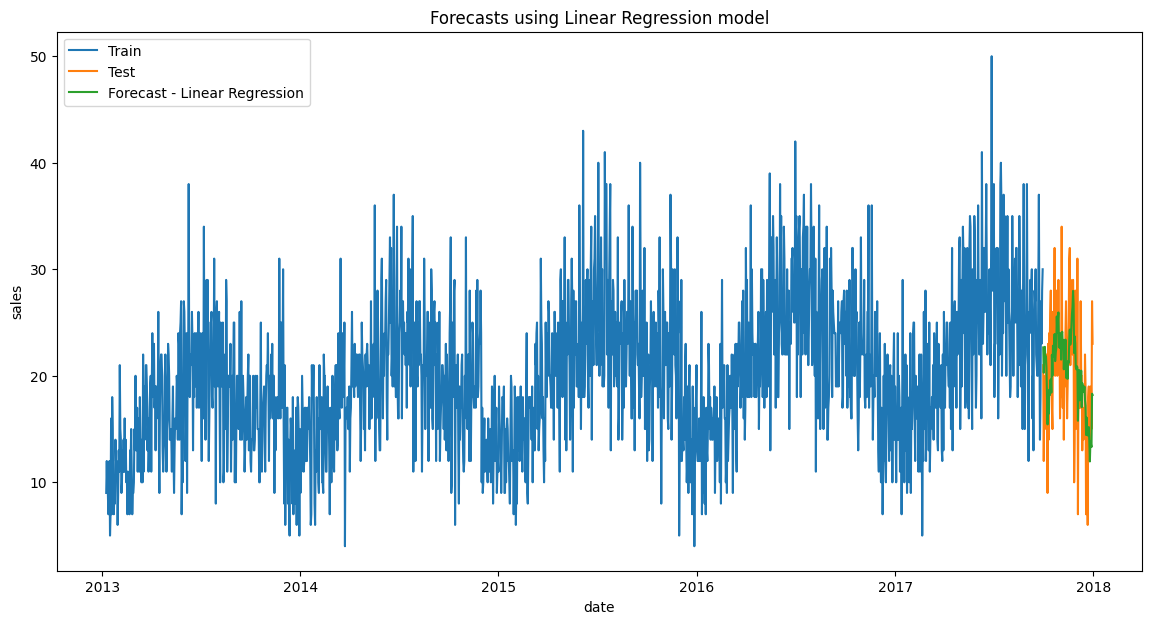

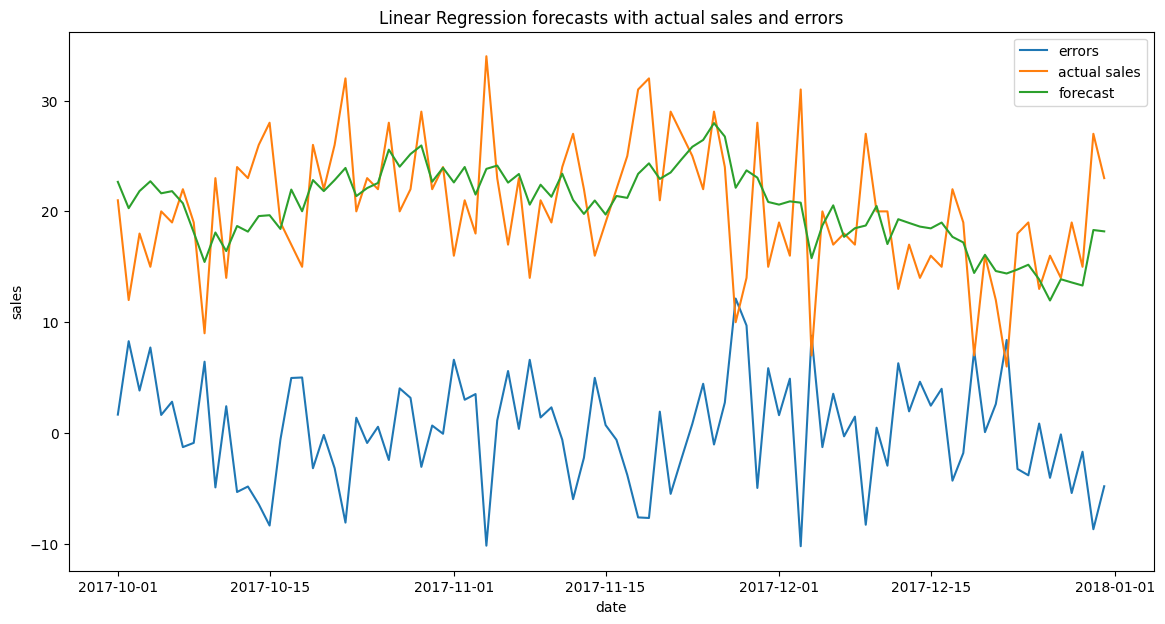

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,1861,1882.074831,21.074831,3.858646,4.786183,19.075519


In [44]:
# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse),
                                          MAPE=('errors', mape))
result_df_lr

<b> Inference: </b> The Linear regression model captures the upwards as well as the downwards movement in the sales data. Its performance, <b> MAPE 19.07% </b>, is better than the Holt-Winters model which was the best performing model so far.

### Conclusion

We considered different time-series models as well as a regression model for time series forecasting. From our results we saw that the linear regression model outperformed the other time-series models. Therefore, for this dataset we could use a regression model, rather than a time-series model to forecast sales. One of the main assumptions of regression models is that the patterns in the historical data will be repeated in the future, and since our data was highly seasonal and had a linear trend, it made sense why the linear regression model out-performed the other models.